In [1]:
# Basics
import mediapipe as mp
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta

# For modelling
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

# Define key functions and test mediapipe model

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [5]:
def get_bbox_coords(results):
    try:
        x_min = min(res.x for res in results.right_hand_landmarks.landmark)
        y_min = min(res.y for res in results.right_hand_landmarks.landmark)
        x_max = max(res.x for res in results.right_hand_landmarks.landmark)
        y_max = max(res.y for res in results.right_hand_landmarks.landmark)
        return x_min, y_min, x_max, y_max
    except: 
        return 0, 0, 0, 0

In [6]:
def draw_bbox(image, results):
    coords = get_bbox_coords(results)
    #print(tuple(np.multiply(coords, [1920, 1080, 1920, 1080]).astype(int)))
    cv2.rectangle(image,
                  tuple(np.multiply(coords[:2], [1920, 1080]).astype(int)),
                  tuple(np.multiply(coords[2:], [1920, 1080]).astype(int)),
                  (0,0,255), 2)

In [7]:
# Define function to extract all values for right hand only!
def extract_keypoints(results):
    """
    Extracts key points from results vector delivered by holistic medipipe model.
    """
    rhand = np.zeros(21*3)
    if results.right_hand_landmarks:
        rhand = np.array([[result.x, result.y, result.z] 
                          for result in results.right_hand_landmarks.landmark]).flatten()
        
    return rhand

In [42]:
cap = cv2.VideoCapture(1)
cv2.startWindowThread()
# Initiate holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():
        # Read frame
        ret, frame = cap.read()
        
        # Make Detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw face_landmarks, pose_landmarks, left_hand_landmarks, right_hand_landmarks
        draw_landmarks(image, results)
        
        # Draw bbox
        draw_bbox(image, results)
        
        # Show to screen
        cv2.imshow('Video Feed', image)
        cv2.waitKey(1)

        # Break program
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [43]:
cap.release()
cv2.destroyAllWindows()

In [ ]:
# Test shape of extracted keypoints
# extract_keypoints(results).shape, 21 * 3

# Setup folder structure

In [8]:
actions = ['fist', 'palm', 'index', 'ok', 'thumb_up']
imgs_per_action = 55

In [9]:
base_path = '../../data/hand_detection_mp/'

In [ ]:
# Delete existing files
#for action in actions:
 #   for file in os.listdir(os.path.join(base_path, action)):
  #      os.remove(os.path.join(base_path, action, file))

# Generate data for hand gestures

In [ ]:
# Take pictures for each ction and save landmarks as numpy array
cap = cv2.VideoCapture(1)
# Initiate holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    for action in actions:
        for img_num in range(imgs_per_action):
            
            # Read frame
            ret, frame = cap.read()

            # Make Detections
            image, results = mediapipe_detection(frame, holistic)

            # Draw face_landmarks, pose_landmarks, left_hand_landmarks, right_hand_landmarks
            draw_landmarks(image, results)

            # Apply wait logic
            if img_num == 0: 
                cv2.putText(image, 'STARTING COLLECTION', (100,200), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                cv2.putText(image, f'Collecting frames for {action}', (15,50), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                # Show to screen
                cv2.imshow('OpenCV Feed', image)
                cv2.waitKey(3000)
            else: 
                cv2.putText(image, f'Collecting frames for {action}, ({img_num}/{imgs_per_action})', (15,50), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                # Show to screen
                cv2.imshow('OpenCV Feed', image)
                cv2.waitKey(1000)

            # Export keypoints
            keypoints = extract_keypoints(results)
            npy_path = os.path.join(base_path, action, f'keypoints_{action}_{img_num}')
            np.save(npy_path, keypoints)



            # Break program
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
                
        # Break program
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

# Preprocess the data

In [10]:
label_map = {action:num for num, action in enumerate(actions)}
label_map

{'fist': 0, 'palm': 1, 'index': 2, 'ok': 3, 'thumb_up': 4}

In [11]:
images, labels = [], []
for action in actions:
    for file in os.listdir(os.path.join(base_path, action)):
        res = np.load(os.path.join(base_path, action, file))
        if all(res != np.zeros(21*3)):
            images.append(res)
            labels.append(label_map[action])

In [12]:
images[0].shape, len(images), len(labels)

((63,), 258, 258)

In [13]:
X = np.array(images)
X.shape

(258, 63)

In [14]:
y = to_categorical(labels).astype(int)
y.shape

(258, 5)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [16]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((232, 63), (232, 5), (26, 63), (26, 5))

# Create neuronal network

In [17]:
K.clear_session()

In [18]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(63,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(actions), activation='softmax'))

In [19]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [20]:
history = model.fit(X_train, y_train, validation_split = 0.1, epochs=250)

Epoch 1/250
7/7 [==============================] - 0s 28ms/step - loss: 1.6137 - categorical_accuracy: 0.2404 - val_loss: 1.5964 - val_categorical_accuracy: 0.2083
Epoch 2/250
7/7 [==============================] - 0s 10ms/step - loss: 1.6010 - categorical_accuracy: 0.2260 - val_loss: 1.6237 - val_categorical_accuracy: 0.2500
Epoch 3/250
7/7 [==============================] - 0s 11ms/step - loss: 1.5934 - categorical_accuracy: 0.2885 - val_loss: 1.6273 - val_categorical_accuracy: 0.1667
Epoch 4/250
7/7 [==============================] - 0s 10ms/step - loss: 1.5905 - categorical_accuracy: 0.2644 - val_loss: 1.6250 - val_categorical_accuracy: 0.2083
Epoch 5/250
7/7 [==============================] - 0s 10ms/step - loss: 1.5826 - categorical_accuracy: 0.3221 - val_loss: 1.6203 - val_categorical_accuracy: 0.2500
Epoch 6/250
7/7 [==============================] - 0s 10ms/step - loss: 1.5779 - categorical_accuracy: 0.3558 - val_loss: 1.6185 - val_categorical_accuracy: 0.2500
Epoch 7/250
7/7 

Epoch 51/250
7/7 [==============================] - 0s 10ms/step - loss: 0.7560 - categorical_accuracy: 0.7308 - val_loss: 0.7564 - val_categorical_accuracy: 0.7500
Epoch 52/250
7/7 [==============================] - 0s 9ms/step - loss: 0.7375 - categorical_accuracy: 0.6971 - val_loss: 0.8111 - val_categorical_accuracy: 0.4167
Epoch 53/250
7/7 [==============================] - 0s 9ms/step - loss: 0.7173 - categorical_accuracy: 0.7212 - val_loss: 0.6776 - val_categorical_accuracy: 0.8333
Epoch 54/250
7/7 [==============================] - 0s 9ms/step - loss: 0.7110 - categorical_accuracy: 0.7885 - val_loss: 0.7194 - val_categorical_accuracy: 0.7500
Epoch 55/250
7/7 [==============================] - 0s 9ms/step - loss: 0.7020 - categorical_accuracy: 0.7644 - val_loss: 0.7269 - val_categorical_accuracy: 0.5833
Epoch 56/250
7/7 [==============================] - 0s 10ms/step - loss: 0.7049 - categorical_accuracy: 0.7692 - val_loss: 0.6814 - val_categorical_accuracy: 0.7917
Epoch 57/250
7

Epoch 101/250
7/7 [==============================] - 0s 10ms/step - loss: 0.2969 - categorical_accuracy: 0.9712 - val_loss: 0.3111 - val_categorical_accuracy: 0.9167
Epoch 102/250
7/7 [==============================] - 0s 10ms/step - loss: 0.2820 - categorical_accuracy: 0.9808 - val_loss: 0.3210 - val_categorical_accuracy: 0.9167
Epoch 103/250
7/7 [==============================] - 0s 9ms/step - loss: 0.2921 - categorical_accuracy: 0.9760 - val_loss: 0.2961 - val_categorical_accuracy: 0.9167
Epoch 104/250
7/7 [==============================] - 0s 9ms/step - loss: 0.2799 - categorical_accuracy: 0.9760 - val_loss: 0.2963 - val_categorical_accuracy: 0.9583
Epoch 105/250
7/7 [==============================] - 0s 9ms/step - loss: 0.2881 - categorical_accuracy: 0.9567 - val_loss: 0.4136 - val_categorical_accuracy: 0.7500
Epoch 106/250
7/7 [==============================] - 0s 9ms/step - loss: 0.2959 - categorical_accuracy: 0.9663 - val_loss: 0.3129 - val_categorical_accuracy: 0.9167
Epoch 10

7/7 [==============================] - 0s 9ms/step - loss: 0.1723 - categorical_accuracy: 0.9808 - val_loss: 0.2924 - val_categorical_accuracy: 0.9583
Epoch 151/250
7/7 [==============================] - 0s 9ms/step - loss: 0.1798 - categorical_accuracy: 0.9808 - val_loss: 0.3287 - val_categorical_accuracy: 0.8750
Epoch 152/250
7/7 [==============================] - 0s 10ms/step - loss: 0.2069 - categorical_accuracy: 0.9712 - val_loss: 0.2950 - val_categorical_accuracy: 0.9583
Epoch 153/250
7/7 [==============================] - 0s 9ms/step - loss: 0.1991 - categorical_accuracy: 0.9760 - val_loss: 0.3017 - val_categorical_accuracy: 0.9583
Epoch 154/250
7/7 [==============================] - 0s 9ms/step - loss: 0.1678 - categorical_accuracy: 0.9808 - val_loss: 0.2881 - val_categorical_accuracy: 0.9583
Epoch 155/250
7/7 [==============================] - 0s 9ms/step - loss: 0.1740 - categorical_accuracy: 0.9808 - val_loss: 0.3038 - val_categorical_accuracy: 0.9583
Epoch 156/250
7/7 [====

7/7 [==============================] - 0s 9ms/step - loss: 0.1525 - categorical_accuracy: 0.9760 - val_loss: 0.3242 - val_categorical_accuracy: 0.9583
Epoch 200/250
7/7 [==============================] - 0s 10ms/step - loss: 0.1420 - categorical_accuracy: 0.9808 - val_loss: 0.3564 - val_categorical_accuracy: 0.9583
Epoch 201/250
7/7 [==============================] - 0s 9ms/step - loss: 0.1499 - categorical_accuracy: 0.9808 - val_loss: 0.3585 - val_categorical_accuracy: 0.9167
Epoch 202/250
7/7 [==============================] - 0s 9ms/step - loss: 0.1369 - categorical_accuracy: 0.9808 - val_loss: 0.3423 - val_categorical_accuracy: 0.9583
Epoch 203/250
7/7 [==============================] - 0s 10ms/step - loss: 0.1361 - categorical_accuracy: 0.9760 - val_loss: 0.3068 - val_categorical_accuracy: 0.9583
Epoch 204/250
7/7 [==============================] - 0s 9ms/step - loss: 0.1340 - categorical_accuracy: 0.9808 - val_loss: 0.3028 - val_categorical_accuracy: 0.9583
Epoch 205/250
7/7 [===

7/7 [==============================] - 0s 10ms/step - loss: 0.1226 - categorical_accuracy: 0.9808 - val_loss: 0.3567 - val_categorical_accuracy: 0.9583
Epoch 249/250
7/7 [==============================] - 0s 10ms/step - loss: 0.1170 - categorical_accuracy: 0.9808 - val_loss: 0.3446 - val_categorical_accuracy: 0.9583
Epoch 250/250
7/7 [==============================] - 0s 10ms/step - loss: 0.1180 - categorical_accuracy: 0.9808 - val_loss: 0.3594 - val_categorical_accuracy: 0.9583


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                2048      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 4,325
Trainable params: 4,325
Non-trainable params: 0
_________________________________________________________________


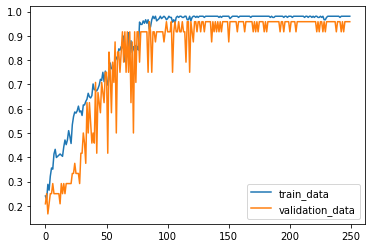

In [22]:
plt.plot(history.history['categorical_accuracy'], label = 'train_data')
plt.plot(history.history['val_categorical_accuracy'], label = 'validation_data')
plt.legend()

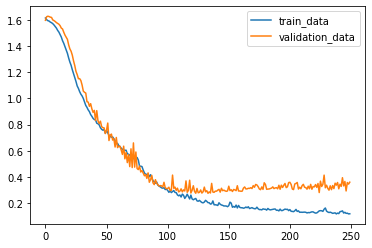

In [23]:
plt.plot(history.history['loss'], label = 'train_data')
plt.plot(history.history['val_loss'], label = 'validation_data')
plt.legend()

# Evaluate model

In [24]:
# Show score for train and test data
model.evaluate(X_train, y_train), model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 26ms/step - loss: 0.3850 - categorical_accuracy: 0.9615


([0.1380220204591751, 0.9784482717514038],
 [0.38499554991722107, 0.9615384936332703])

In [25]:
# Determine predictions for test data
y_pred = model.predict(X_test)

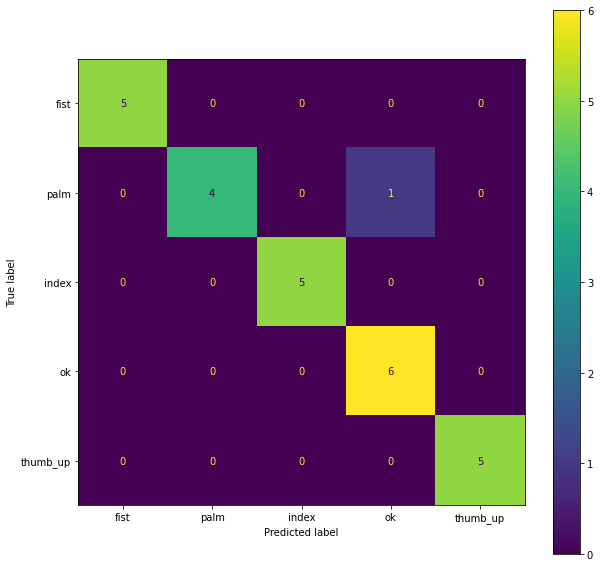

In [26]:
# Plot confusion matrix
cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=np.argmax(y_pred, axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=actions)

fig, ax = plt.subplots(figsize=(10,10))

disp.plot(ax=ax);

In [ ]:
model.save('hand_gesture_model.h5')

# Realtime gesture detection

In [33]:
# Load model from h5 file hand_detection_model.ipynbre for testing purposes)
model = load_model('hand_gesture_model.h5')

In [44]:
cap = cv2.VideoCapture(1)
cv2.startWindowThread()

# Initialize variables
datetime_prv = datetime.now() - timedelta(seconds=1)
class_prob = 0

# Initiate holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():
        # Read frame
        ret, frame = cap.read()
        
        # Make Detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw face_landmarks, pose_landmarks, left_hand_landmarks, right_hand_landmarks
        draw_landmarks(image, results)
        
        # NEW predict hand gesture
        if datetime.now() >= datetime_prv + timedelta(seconds=0.5) and results.right_hand_landmarks:
            img = image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            keypoints = extract_keypoints(results) 
            keypoints = keypoints.reshape(1,-1)
            y_pred = model.predict(keypoints)
            class_id = np.argmax(y_pred)
            class_prob = np.max(y_pred)
            coords = get_bbox_coords(results)
            
        # NEW draw handgesture if detetced
        if class_prob > 0.5 and results.right_hand_landmarks:
        
            # Draw bbox around hand
            draw_bbox(image, results)

            # Draw label box
            coords = get_bbox_coords(results)
            cv2.rectangle(image,
                          tuple(np.add(np.multiply(coords[:2], [1920, 1080]).astype(int), [0, -30])),
                          tuple(np.add(np.multiply(coords[:2], [1920, 1080]).astype(int), [80, 0])),
                          (0,0,255), -1)

            # Put text in label
            cv2.putText(image, f'{actions[class_id]}', 
                        tuple(np.add(np.multiply(coords[:2], [1920, 1080]).astype(int), [0, -5])),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Video Feed', image)
        cv2.waitKey(1)

        # Break program
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [45]:
cap.release()
cv2.destroyAllWindows()